## Download data

In [1]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1ggZSZSM4JWn40v2ms6sFePJaLZ7IDa5s

!unzip /content/data_final.zip

!rm -f /content/data_final.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ggZSZSM4JWn40v2ms6sFePJaLZ7IDa5s
To: /content/data_final.zip
100% 638M/638M [00:07<00:00, 84.6MB/s]
Archive:  /content/data_final.zip
   creating: data_final/
  inflating: data_final/train_annotation.txt  
  inflating: data_final/test_annotation.txt  
   creating: data_final/train/
  inflating: data_final/train/673b64e17.jpg  
  inflating: data_final/train/15153bb54.jpg  
  inflating: data_final/train/3ed7c19f0.jpg  
  inflating: data_final/train/bb808af6f.jpg  
  inflating: data_

## Import 

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from tqdm import tqdm
%matplotlib inline



## EDA

In [3]:
import pandas as pd
df = pd.read_csv('/content/data_final/train.csv')
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
df['source'].value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

## Visualize image to test label

394 775 112 103


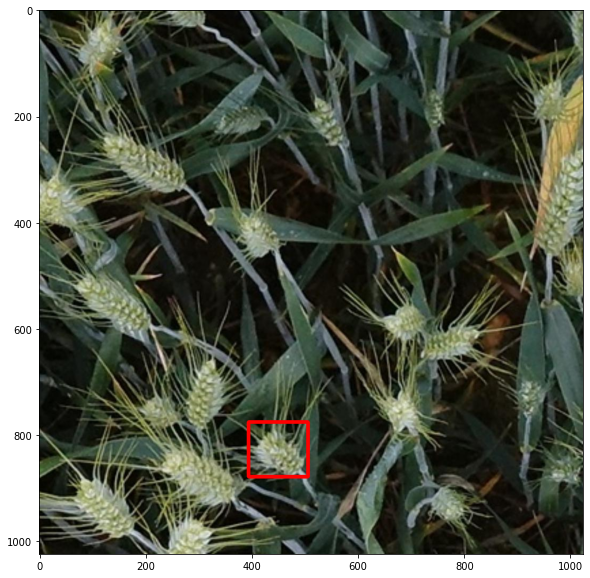

In [6]:
import json
row = df[df['source']=='inrae_1'].reset_index().loc[1]
img = cv2.imread(f"/content/data_final/train/{row.image_id}.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bbox = json.loads(row.bbox)
x, y, w, h = int(bbox[0]),int(bbox[1]),int(bbox[2]),int(bbox[3])
print(x, y, w, h)
img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 5)

plt.figure(figsize=(10,10))
plt.imshow(img)

## Save template for per source in dataset. Template belong with source have max area

In [7]:
sources = df['source'].unique()
templates = {}

def get_area(x):
  bbox = json.loads(x.bbox)
  w, h = int(bbox[2]), int(bbox[3])
  return w*h

for source in sources:
  df_source = df[df['source']==source].reset_index()

  # calculate area for per source
  df_source['area'] = df_source.apply(get_area, axis = 1)

  # get median area
  template = []
  bboxes = []
  for i in [0.0, 0.25, 0.5, 0.75, 1.0]:
    index = np.quantile(df_source['area'].index, i)
    row = df_source.loc[int(index)]

    # read full image
    img = cv2.imread(f"/content/data_final/train/{row.image_id}.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bbox = json.loads(row.bbox)
    # get crop image
    x, y, w, h = int(bbox[0]),int(bbox[1]),int(bbox[2]),int(bbox[3])
    crop_img = img[y:y+h, x:x+w]
    template.append(crop_img)
    bboxes.append([str(x), str(y), str(x+w), str(y+h)])

  templates[source] = {
      'image':template,
      'bbox':bboxes
  }

templates[sources[0]]['image'][0].shape

(36, 56, 3)

In [8]:
templates[sources[0]]['bbox'][4]

['111', '0', '157', '19']

## Create Grouth-Truth to calculate MAP

In [9]:
import os
from glob2 import glob

base_folder = '/content/input/ground-truth'
os.makedirs(base_folder, exist_ok = True)
lst_imgs = glob('/content/data_final/train/**/*.jpg')

prev_id = ''
for index in tqdm(df.index):
  row = df.loc[index]
  image_id = row.image_id

  if prev_id == image_id:
    continue

  prev_id = image_id
  source = row.source

  bboxes = templates[source]['bbox']
  with open(f'{base_folder}/{image_id}.txt', 'w') as fi:
    for bbox in bboxes:
      x1,y1,x2,y2 = bbox[0],bbox[1],bbox[2],bbox[3]
      fi.writelines(f'{source} {x1} {y1} {x2} {y2}\n') # format of grouth-truth is <source> <x1> <y1> <x2> <y2>

100%|██████████| 147793/147793 [00:19<00:00, 7502.44it/s]


## Create result to calculate MAP

In [ ]:
def get_final_bbox(img, template, method):
  img_copy = img.copy()
  # img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
  # template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
  res = cv2.matchTemplate(img_copy, template, method)     
  THRESHOLD = np.quantile(res, q = 0.998)

  loc = np.where(res >= THRESHOLD)
  scores = res[res>=THRESHOLD]

  h, w = template.shape[:2]
  boxes_detected = []
  confidences_scores = []

  for y, x, s in zip(loc[0], loc[1], scores):
    boxes_detected.append([x, y, w, h])
    confidences_scores.append(s)

  # calculate NMS
  final_boxes = cv2.dnn.NMSBoxes(boxes_detected, confidences_scores, THRESHOLD, 0.03,)
  boxes_detected = np.array(boxes_detected)
  confidences_scores = np.array(confidences_scores)
  return boxes_detected[final_boxes], confidences_scores[final_boxes]


base_folder = '/content/input/detection-results'
os.makedirs(base_folder, exist_ok = True)


# All the 6 methods in a list
# Note how we are using string, later on we'll use the eval() function
# for more detaild of methods check documentation
methods = ['cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCOEFF',
           'cv2.TM_CCORR', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED',
           'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

# Get function in index 1           
method = eval(methods[4])

prev_img_id = ''
for index in tqdm(df.index):
  row = df.loc[index]
  img_id = row.image_id

  if prev_img_id == img_id:
    continue
  prev_img_id = img_id
  img = cv2.imread(f'/content/data_final/train/{img_id}.jpg')

  result = []

  # run each image with all source
  for source, template in templates.items():
    for i, t in enumerate(template['image']):
      bboxes, scores = get_final_bbox(img, t, method)
      for bbox, score in zip(bboxes, scores):
        x,y,w,h = bbox[0],bbox[1],bbox[2],bbox[3]
        result.append(f'{source} {score} {x} {y} {x+w} {y+h}')
  
  # Save result to file to calculate mAP
  with open(f'{base_folder}/{img_id}.txt', 'w') as fi:
    fi.writelines('\n'.join(result)) # format is: <source> <confidence> <x1> <y1> <x2> <y2>
    

  ## Plot result  
  # plt.subplot(121)
  # plt.imshow(res)
  # plt.title('HEATMAP OF TEMPLATE MATCHING')
  
  # plt.subplot(122)
  # plt.imshow(test_img_copy)
  # plt.title('DETECTION OF TEMPLATE')
  
  # # Title with the method used
  # plt.suptitle(m + f"_{source}")
  
  # plt.show()
  # print('\n\n\n')
  # print(lst_imgs[0])


    

  0%|          | 483/147793 [00:52<4:23:27,  9.32it/s]

In [ ]:
img_id

'b6ab77fd7'

## Calculate mAP

In [ ]:
!git clone https://github.com/TrungDS10/mAP.git

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 36.56 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [ ]:
%cd /content/mAP
!python main.py -na -np

/content/mAP
0.00000% = arvalis_1 AP 
0.00000% = arvalis_2 AP 
0.00000% = arvalis_3 AP 
0.00000% = ethz_1 AP 
0.00000% = inrae_1 AP 
0.00000% = rres_1 AP 
0.00000% = usask_1 AP 
mAP = 0.00%
